In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, chi2, f_classif
from sklearn.preprocessing import MinMaxScaler

#### 6.1. Load Preprocessed Datasets

We load the train, validation, and test sets that have undergone feature engineering.
These datasets are ready for feature selection and model training.

In [2]:
df_train = pd.read_parquet("./data/5/df_train.parquet")
df_test = pd.read_parquet("./data/5/df_test.parquet")
df_val = pd.read_parquet("./data/5/df_val.parquet")

#### 6.2. Remove Low-Variance Features

Columns with very low variance contribute little to model learning and can be safely removed.
- `VarianceThreshold` removes features with variance below 0.01.
- We print the removed columns and their variances for transparency.
- The remaining columns are kept for further analysis.

In [3]:
variance_selector = VarianceThreshold(threshold=0.01)
variance_selector.fit(df_train)

variances = pd.Series(variance_selector.variances_, index=df_test.columns)
keep_columns = variances[variance_selector.get_support()].index
drop_columns = variances[~variance_selector.get_support()].index

print("Columns with low variance (< 0.01):")
for col in drop_columns.sort_values(key=lambda x: variances[x]):
    print(f"  - {col} (variance = {variances[col]:.6f})")

df_train, df_test, df_val = df_train[keep_columns], df_test[keep_columns], df_val[keep_columns]

Columns with low variance (< 0.01):
  - sender_receiver_same (variance = 0.000000)
  - isFlaggedFraud (variance = 0.000019)
  - type_encoded (variance = 0.000055)
  - amount_over_sender_max (variance = 0.003177)
  - amount_over_mean_sender (variance = 0.004138)
  - sender_tx_count (variance = 0.004894)


#### 6.3. Prepare Features and Target

- `X_train` contains all numeric features except the target `isFraud`.
- `y_train` is the target variable for fraud detection.
- We also extract the list of numeric columns to use in statistical feature selection methods.

In [4]:
X_train, y_train = df_train.drop(columns=["isFraud"]), df_train["isFraud"]
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()

#### 6.4. Statistical Feature Selection

We evaluate the importance of numeric features using multiple statistical methods:
1. **Mutual Information (MI)** – measures the dependency between each feature and the target.
2. **Chi-squared Test (Chi2)** – evaluates the independence between categorical features and the target.
3. **ANOVA F-test (F-test)** – assesses whether feature means differ significantly across target classes.
4. **Correlation** – absolute correlation of each feature with the target.

- Scores are normalized to a 0-1 range to allow comparison across methods.
- A combined score is calculated as the mean of all normalized scores.

We create a horizontal bar plot comparing the normalized scores from different feature selection methods:
- Each feature is represented on the y-axis.
- Each statistical test score is shown as a separate bar with different colors.
- Values are annotated on the bars for clarity.

This visualization helps identify features that consistently perform well across multiple selection criteria.
It provides an intuitive way to prioritize features for model training.

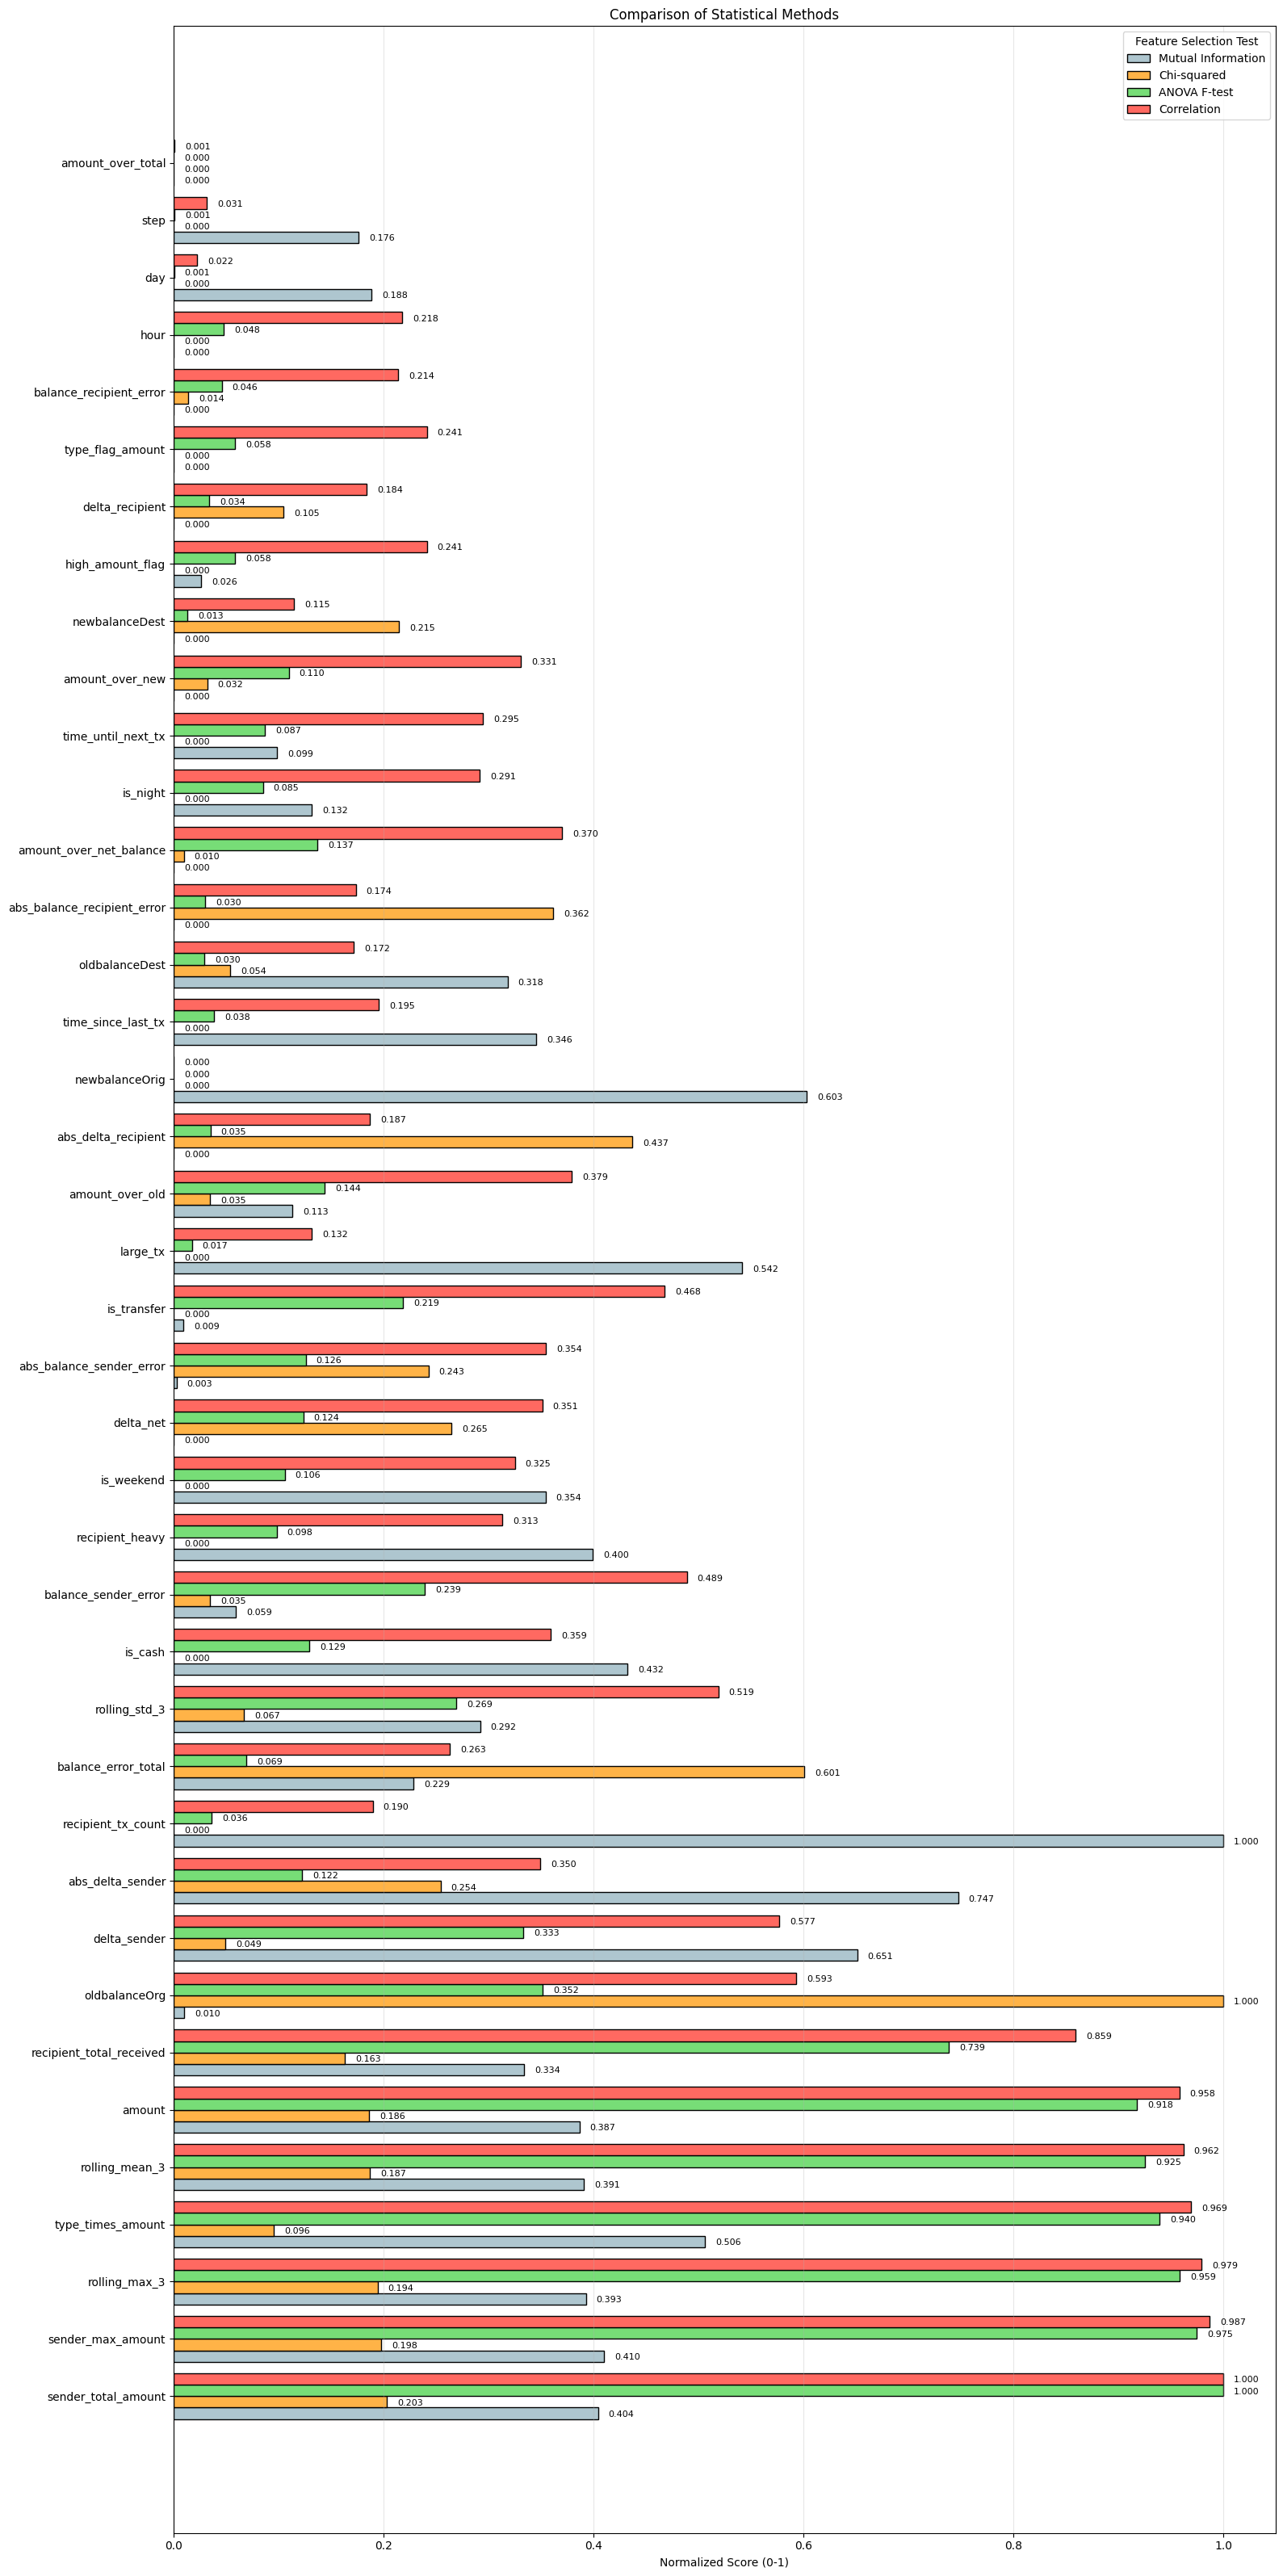

In [5]:
mi_scores = mutual_info_classif(X_train[numeric_cols], y_train, random_state=0)
chi_scores, _ = chi2(X_train[numeric_cols]-X_train[numeric_cols].min(), y_train)
f_scores, _ = f_classif(X_train[numeric_cols], y_train)
corr_scores = X_train[numeric_cols].corrwith(y_train).abs()

scores = pd.DataFrame({
    "Feature": numeric_cols,
    "Mutual Information": mi_scores,
    "Chi-squared": chi_scores,
    "ANOVA F-test": f_scores,
    "Correlation": corr_scores
})

scaler = MinMaxScaler()
score_columns = ["Mutual Information", "Chi-squared", "ANOVA F-test", "Correlation"]
scores[score_columns] = scaler.fit_transform(scores[score_columns])
scores["Combined"] = scores[score_columns].mean(axis=1)
scores_sorted = scores.sort_values("Combined", ascending=False)

num_features = len(scores_sorted)
y_positions = np.arange(num_features)
width = 0.2
colors = ["#AEC6CF", "#FFB347", "#77DD77", "#FF6961"]
labels = score_columns

plt.figure(figsize=(16, 0.8*num_features))
bars_list = []
for i, (label, color) in enumerate(zip(labels, colors)):
    bars_list.append(plt.barh(
        y_positions + (i-1.5)*width,
        scores_sorted[label],
        width,
        label=label,
        color=color,
        edgecolor="black"
    ))

for i, label in enumerate(labels):
    for bar, val in zip(bars_list[i], scores_sorted[label]):
        plt.text(bar.get_width()+0.01, bar.get_y()+bar.get_height()/2-0.02, f"{val:.3f}", va="center", fontsize=8)

plt.yticks(y_positions, scores_sorted["Feature"])
plt.xlabel("Normalized Score (0-1)")
plt.title("Comparison of Statistical Methods")
plt.grid(axis="x", alpha=0.3)
plt.legend(title="Feature Selection Test")
plt.tight_layout()
plt.show()

#### 6.5. Save Feature-Selected Datasets

After low-variance removal and feature evaluation, we save the updated datasets:
- Preserves selected features for train, validation, and test sets
- Ensures reproducibility for model training

In [6]:
os.makedirs("./data/6/", exist_ok=True)

df_train.to_parquet("./data/6/df_train.parquet", index=False)
df_val.to_parquet("./data/6/df_val.parquet", index=False)
df_test.to_parquet("./data/6/df_test.parquet", index=False)